# OptNet/qpth Example Notebook

*Brandon Amos and J. Zico Kolter*

---

This notebook is released along with our paper
[OptNet: Differentiable Optimization as a Layer in Neural Networks](https://arxiv.org/abs/1703.00443).

This notebook shows a minimal example of constructing an
OptNet layer in PyTorch with our [qpth library](https://github.com/locuslab/qpth).
See [our qpth documentation page](https://locuslab.github.io/qpth/)
for more details.
The experiments for our paper that use this library are in
[this repo](https://github.com/locuslab/optnet).


## Setup and Dependencies

+ Python/numpy/[PyTorch](https://pytorch.org)
+ [qpth](https://github.com/locuslab/qpth):
  *Our fast QP solver for PyTorch released in conjunction with this paper.*
+ [bamos/block](https://github.com/bamos/block):
  *Our intelligent block matrix library for numpy, PyTorch, and beyond.*
+ Optional: [bamos/setGPU](https://github.com/bamos/setGPU):
  A small library to set `CUDA_VISIBLE_DEVICES` on multi-GPU systems.

In [1]:
import torch

import torch.nn as nn
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from qpth.qp import QPFunction

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

# Define the model

+ We'll be using a network architecture that looks like:

```
FC-ReLU-(BN)-FC-ReLU-(BN)-QP-softmax
```

where the QP OptNet layer learns the coefficients `Q`, `q`, `G`, and `h` for
a QP with inequality constraints:

```
z_{i+1} = argmin_z 0.5 z^T Q z + q^t z
          s.t. Gz <= h
```

In [2]:
class OptNet(nn.Module):
    def __init__(self, nFeatures, nHidden, nCls, bn, nineq=200, neq=0, eps=1e-4):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden = nHidden
        self.bn = bn
        self.nCls = nCls
        self.nineq = nineq
        self.neq = neq
        self.eps = eps

        # Normal BN/FC layers.
        if bn:
            self.bn1 = nn.BatchNorm1d(nHidden)
            self.bn2 = nn.BatchNorm1d(nCls)

        self.fc1 = nn.Linear(nFeatures, nHidden)
        self.fc2 = nn.Linear(nHidden, nCls)

        # QP params.
        self.M = Variable(torch.tril(torch.ones(nCls, nCls)).cuda())
        self.L = Parameter(torch.tril(torch.rand(nCls, nCls).cuda()))
        self.G = Parameter(torch.Tensor(nineq,nCls).uniform_(-1,1).cuda())
        self.z0 = Parameter(torch.zeros(nCls).cuda())
        self.s0 = Parameter(torch.ones(nineq).cuda())

    def forward(self, x):
        nBatch = x.size(0)

        # Normal FC network.
        x = x.view(nBatch, -1)
        x = F.relu(self.fc1(x))
        if self.bn:
            x = self.bn1(x)
        x = F.relu(self.fc2(x))
        if self.bn:
            x = self.bn2(x)

        # Set up the qp parameters Q=LL^T and h = Gz_0+s_0.
        L = self.M*self.L
        Q = L.mm(L.t()) + self.eps*Variable(torch.eye(self.nCls)).cuda()
        h = self.G.mv(self.z0)+self.s0
        e = Variable(torch.Tensor())
        x = QPFunction(verbose=-1)(Q, x, self.G, h, e, e)

        return F.log_softmax(x)

# Train the network

+ Create random data for a regression task and then optimize the parameters with Adam.

In [3]:
# Create random data
nBatch, nFeatures, nHidden, nCls = 16, 20, 20, 2
x = Variable(torch.randn(nBatch, nFeatures).cuda(), requires_grad=False)
y = Variable((torch.rand(nBatch) < 0.5).long().cuda(), requires_grad=False)

In [4]:
# Initialize the model.
model = OptNet(nFeatures, nHidden, nCls, bn=False).cuda()
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 25 == 0:
        print('Iteration {}, loss = {:.2f}'.format(t, loss.data[0]))
    losses.append(loss.data[0])

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

Iteration 0, loss = 0.73
Iteration 25, loss = 0.69
Iteration 50, loss = 0.65
Iteration 75, loss = 0.57
Iteration 100, loss = 0.57
Iteration 125, loss = 0.56
Iteration 150, loss = 0.51
Iteration 175, loss = 0.50
Iteration 200, loss = 0.49
Iteration 225, loss = 0.48
Iteration 250, loss = 0.47
Iteration 275, loss = 0.46
Iteration 300, loss = 0.45
Iteration 325, loss = 0.45
Iteration 350, loss = 0.45
Iteration 375, loss = 0.45
Iteration 400, loss = 0.43
Iteration 425, loss = 0.42
Iteration 450, loss = 0.42
Iteration 475, loss = 0.41


(0.0, 0.75834574848413472)

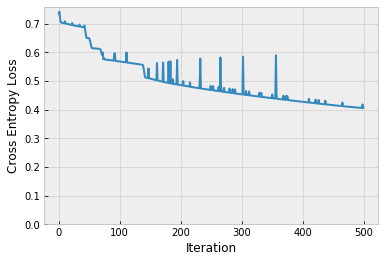

In [6]:
plt.plot(losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylim(ymin=0.)